In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=144 
currency = ["CHF","CAD","GBP","JPY","EUR","HKD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 40
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, typeq):

    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])

    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     

    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [7]:

"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=5))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [8]:

"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
(None, 26, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4767 MiB, count=2, average=2384 MiB
[Training model......]
Train on 549690 samples, validate on 164880 samples
Epoch 1/20
549690/549690 [==============================] - 1226s 2ms/step - loss: 5.3603 - acc: 0.4976 - val_loss: 1.3556 - val_acc: 0.5739
Epoch 2/20
549690/549690 [==============================] - 57s 103us/step - loss: 2.0015 - acc: 0.5277 - val_loss: 0.7416 - val_acc: 0.5941
Epoch 3/20
549690/549690 [==============================] - 57s 104us/step - loss: 0.9959 - acc: 0.5413 - val_loss: 0.6711 - val_acc: 0.6074
Epoch 4/20
549690/549690 [==============================] - 57s 104us/step - loss: 0.7722 - acc: 0.5517 - val_loss: 0.6535 - val_acc: 0.6002
Epoch 5/20
549690/549690 [==============================] - 57s 104us/step - loss: 0.7006 - acc: 0.5628 - val_loss: 0.6476 - val_acc: 0.5990
Epoch 6/20
549690/549690

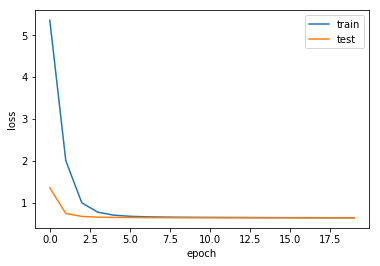

acc:
0.6061416434769797
val_acc:
0.6030810287367772


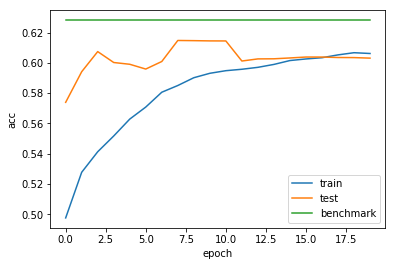

(148335, 1)
finish dataread
(None, 26, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=9596 MiB, count=1410, average=6969 KiB
[Training model......]
Train on 535650 samples, validate on 188310 samples
Epoch 1/20
535650/535650 [==============================] - 1462s 3ms/step - loss: 4.6242 - acc: 0.5003 - val_loss: 0.7483 - val_acc: 0.5577
Epoch 2/20
535650/535650 [==============================] - 56s 105us/step - loss: 1.4316 - acc: 0.5316 - val_loss: 0.6462 - val_acc: 0.5985
Epoch 3/20
535650/535650 [==============================] - 57s 106us/step - loss: 0.8355 - acc: 0.5508 - val_loss: 0.6382 - val_acc: 0.6094
Epoch 4/20
535650/535650 [==============================] - 57s 106us/step - loss: 0.7094 - acc: 0.5656 - val_loss: 0.6366 - val_acc: 0.6062
Epoch 5/20
535650/535650 [==============================] - 57s 106us/step - loss: 0.6725 - acc: 0.5743 - val_loss: 0.6361 - val_acc: 0.6062
Epoch 6/20
535650/535

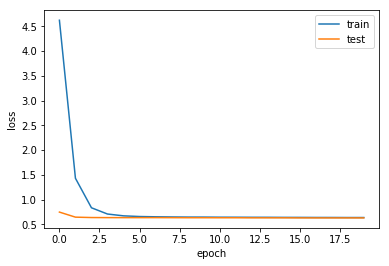

acc:
0.5998991877850415
val_acc:
0.6106898194699918


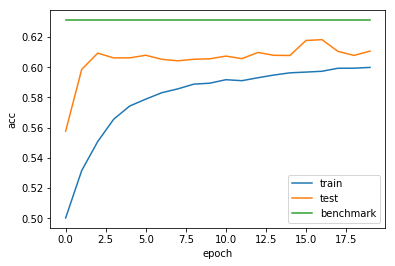

(148335, 1)
finish dataread
(None, 26, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=9776 MiB, count=1411, average=7095 KiB
[Training model......]
Train on 560340 samples, validate on 181440 samples
Epoch 1/20
560340/560340 [==============================] - 1467s 3ms/step - loss: 4.3838 - acc: 0.5209 - val_loss: 0.9175 - val_acc: 0.5771
Epoch 2/20
560340/560340 [==============================] - 59s 105us/step - loss: 1.4377 - acc: 0.5349 - val_loss: 0.6738 - val_acc: 0.5815
Epoch 3/20
560340/560340 [==============================] - 59s 105us/step - loss: 0.7867 - acc: 0.5556 - val_loss: 0.6561 - val_acc: 0.5970
Epoch 4/20
560340/560340 [==============================] - 59s 104us/step - loss: 0.6844 - acc: 0.5656 - val_loss: 0.6503 - val_acc: 0.6081
Epoch 5/20
560340/560340 [==============================] - 58s 104us/step - loss: 0.6614 - acc: 0.5714 - val_loss: 0.6466 - val_acc: 0.6106
Epoch 6/20
560340/560

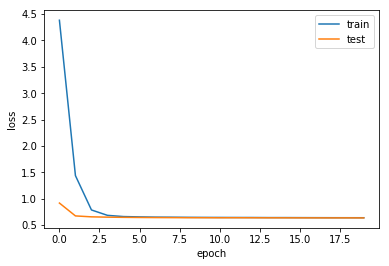

acc:
0.6010654245611049
val_acc:
0.599823633325163


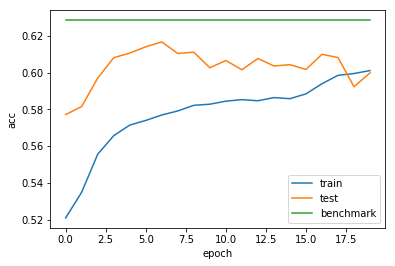

(148335, 1)
finish dataread
(None, 26, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=9781 MiB, count=1412, average=7093 KiB
[Training model......]
Train on 551910 samples, validate on 172800 samples
Epoch 1/20
551910/551910 [==============================] - 1502s 3ms/step - loss: 6.3289 - acc: 0.4921 - val_loss: 3.5904 - val_acc: 0.5371
Epoch 2/20
551910/551910 [==============================] - 57s 104us/step - loss: 2.6342 - acc: 0.5170 - val_loss: 0.7760 - val_acc: 0.5658
Epoch 3/20
551910/551910 [==============================] - 58s 104us/step - loss: 1.0389 - acc: 0.5291 - val_loss: 0.6712 - val_acc: 0.5811
Epoch 4/20
551910/551910 [==============================] - 58s 104us/step - loss: 0.7873 - acc: 0.5455 - val_loss: 0.6557 - val_acc: 0.6040
Epoch 5/20
551910/551910 [==============================] - 58s 104us/step - loss: 0.7164 - acc: 0.5583 - val_loss: 0.6523 - val_acc: 0.5918
Epoch 6/20
551910/551

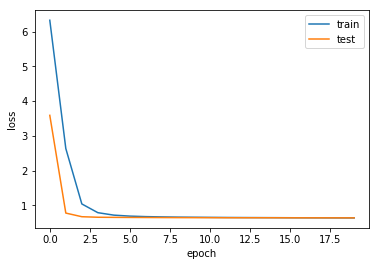

acc:
0.6147777715945096
val_acc:
0.6023726851851852


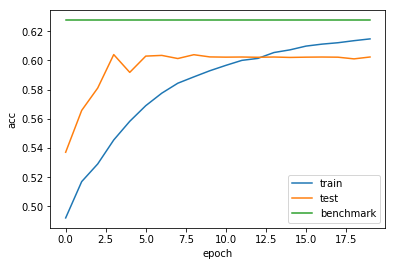

(148335, 1)
finish dataread
(None, 26, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=9834 MiB, count=1416, average=7112 KiB
[Training model......]
Train on 559830 samples, validate on 190080 samples
Epoch 1/20
559830/559830 [==============================] - 1540s 3ms/step - loss: 4.8299 - acc: 0.4892 - val_loss: 0.8896 - val_acc: 0.5825
Epoch 2/20
559830/559830 [==============================] - 59s 105us/step - loss: 1.4397 - acc: 0.5375 - val_loss: 0.6715 - val_acc: 0.6093
Epoch 3/20
559830/559830 [==============================] - 59s 105us/step - loss: 0.8554 - acc: 0.5586 - val_loss: 0.6510 - val_acc: 0.6092
Epoch 4/20
559830/559830 [==============================] - 59s 105us/step - loss: 0.7242 - acc: 0.5713 - val_loss: 0.6466 - val_acc: 0.6092
Epoch 5/20
559830/559830 [==============================] - 59s 105us/step - loss: 0.6813 - acc: 0.5812 - val_loss: 0.6440 - val_acc: 0.6096
Epoch 6/20
559830/559

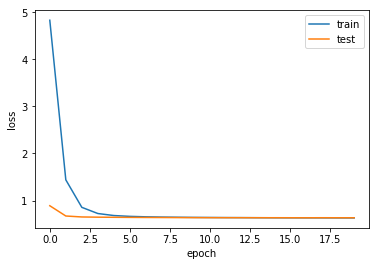

acc:
0.6148991656759519
val_acc:
0.6006155304635815


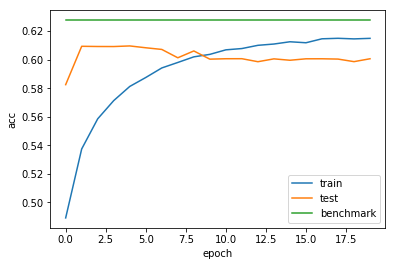

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 144, 6)       0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 140, 20)      620         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 136, 20)      2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 132, 20)      2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

                                                                 concatenate_10[156][0]           
                                                                 concatenate_10[157][0]           
                                                                 concatenate_10[158][0]           
                                                                 concatenate_10[159][0]           
                                                                 concatenate_10[160][0]           
                                                                 concatenate_10[161][0]           
                                                                 concatenate_10[162][0]           
                                                                 concatenate_10[163][0]           
                                                                 concatenate_10[164][0]           
                                                                 concatenate_10[165][0]           
          

                                                                 dense_55[624][0]                 
                                                                 dense_55[625][0]                 
                                                                 dense_55[626][0]                 
                                                                 dense_55[627][0]                 
                                                                 dense_55[628][0]                 
                                                                 dense_55[629][0]                 
                                                                 dense_55[630][0]                 
                                                                 dense_55[631][0]                 
                                                                 dense_55[632][0]                 
                                                                 dense_55[633][0]                 
          

train_acc:red,test_acc:blue


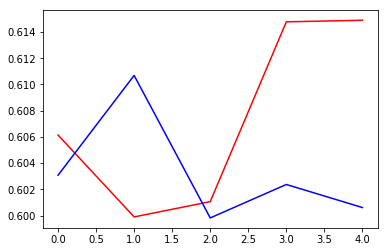

train_loss:red,test_loss:blue


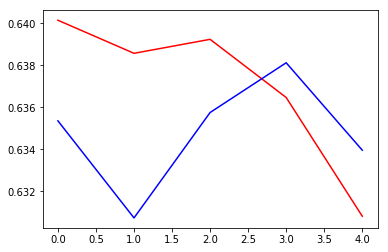

trend:red,vol:blue


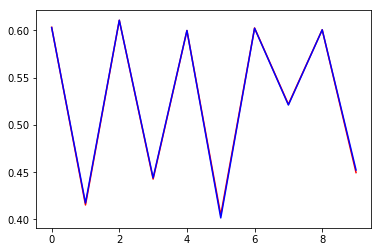

In [11]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [12]:
K.clear_session()

In [8]:

"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    


In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 9
tail = 21
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])

(148335, 1)
finish dataread
(None, 26, 1)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=4816 MiB, count=2, average=2408 MiB
[Training model......]
Train on 543060 samples, validate on 178920 samples
Epoch 1/40
543060/543060 [==============================] - 1304s 2ms/step - loss: 3.8564 - acc: 0.5339 - val_loss: 0.8040 - val_acc: 0.6231
Epoch 2/40
543060/543060 [==============================] - 57s 105us/step - loss: 1.7045 - acc: 0.5361 - val_loss: 0.6591 - val_acc: 0.6128
Epoch 3/40
543060/543060 [==============================] - 57s 105us/step - loss: 1.0036 - acc: 0.5442 - val_loss: 0.6318 - val_acc: 0.6194
Epoch 4/40
543060/543060 [==============================] - 57s 105us/step - loss: 0.7973 - acc: 0.5569 - val_loss: 0.6270 - val_acc: 0.6254
Epoch 5/40
543060/543060 [==============================] - 57s 105us/step - loss: 0.7233 - acc: 0.5665 - val_loss: 0.6245 - val_acc: 0.6368
Epoch 6/40
543060/543060 

553980/553980 [==============================] - 58s 104us/step - loss: 0.6474 - acc: 0.5904 - val_loss: 0.6295 - val_acc: 0.6394
Epoch 12/40
553980/553980 [==============================] - 58s 104us/step - loss: 0.6467 - acc: 0.5923 - val_loss: 0.6291 - val_acc: 0.6397
Epoch 13/40
553980/553980 [==============================] - 58s 104us/step - loss: 0.6458 - acc: 0.5922 - val_loss: 0.6290 - val_acc: 0.6393
Epoch 14/40
553980/553980 [==============================] - 58s 104us/step - loss: 0.6444 - acc: 0.5937 - val_loss: 0.6283 - val_acc: 0.6396
Epoch 15/40
553980/553980 [==============================] - 58s 104us/step - loss: 0.6436 - acc: 0.5943 - val_loss: 0.6275 - val_acc: 0.6390
Epoch 16/40
553980/553980 [==============================] - 58s 104us/step - loss: 0.6446 - acc: 0.5934 - val_loss: 0.6277 - val_acc: 0.6351
Epoch 17/40
553980/553980 [==============================] - 58s 104us/step - loss: 0.6429 - acc: 0.5968 - val_loss: 0.6276 - val_acc: 0.6311
Epoch 18/40
553980

541140/541140 [==============================] - 56s 104us/step - loss: 0.6417 - acc: 0.6129 - val_loss: 0.6251 - val_acc: 0.6336
Epoch 24/40
541140/541140 [==============================] - 56s 104us/step - loss: 0.6414 - acc: 0.6151 - val_loss: 0.6237 - val_acc: 0.6439
Epoch 25/40
541140/541140 [==============================] - 56s 104us/step - loss: 0.6410 - acc: 0.6141 - val_loss: 0.6254 - val_acc: 0.6436
Epoch 26/40
541140/541140 [==============================] - 56s 104us/step - loss: 0.6409 - acc: 0.6166 - val_loss: 0.6243 - val_acc: 0.6425
Epoch 27/40
541140/541140 [==============================] - 56s 104us/step - loss: 0.6401 - acc: 0.6163 - val_loss: 0.6232 - val_acc: 0.6413
Epoch 28/40
541140/541140 [==============================] - 56s 104us/step - loss: 0.6406 - acc: 0.6163 - val_loss: 0.6240 - val_acc: 0.6440
Epoch 29/40
541140/541140 [==============================] - 56s 104us/step - loss: 0.6398 - acc: 0.6174 - val_loss: 0.6244 - val_acc: 0.6403
Epoch 30/40
541140

Epoch 35/40
549690/549690 [==============================] - 57s 103us/step - loss: 0.6359 - acc: 0.6113 - val_loss: 0.6265 - val_acc: 0.6268
Epoch 36/40
549690/549690 [==============================] - 57s 103us/step - loss: 0.6365 - acc: 0.6114 - val_loss: 0.6271 - val_acc: 0.6141
Epoch 37/40
549690/549690 [==============================] - 57s 103us/step - loss: 0.6355 - acc: 0.6121 - val_loss: 0.6267 - val_acc: 0.6268
Epoch 38/40
549690/549690 [==============================] - 57s 103us/step - loss: 0.6360 - acc: 0.6132 - val_loss: 0.6271 - val_acc: 0.6194
Epoch 39/40
549690/549690 [==============================] - 57s 103us/step - loss: 0.6350 - acc: 0.6145 - val_loss: 0.6279 - val_acc: 0.6268
Epoch 40/40
549690/549690 [==============================] - 57s 103us/step - loss: 0.6358 - acc: 0.6098 - val_loss: 0.6263 - val_acc: 0.6268
[[0.50891376]
 [0.5085513 ]
 [0.50891376]
 ...
 [0.6320216 ]
 [0.64748746]
 [0.65837246]]
103353 0.6268377001455604
trend_test_acc:
51557 0.62538816

560340/560340 [==============================] - 1527s 3ms/step - loss: 3.6348 - acc: 0.5291 - val_loss: 0.8735 - val_acc: 0.6099
Epoch 2/40
560340/560340 [==============================] - 59s 105us/step - loss: 1.5885 - acc: 0.5318 - val_loss: 0.6307 - val_acc: 0.6262
Epoch 3/40
560340/560340 [==============================] - 59s 105us/step - loss: 0.9739 - acc: 0.5432 - val_loss: 0.6178 - val_acc: 0.6300
Epoch 4/40
560340/560340 [==============================] - 59s 105us/step - loss: 0.7780 - acc: 0.5569 - val_loss: 0.6222 - val_acc: 0.6335
Epoch 5/40
560340/560340 [==============================] - 59s 105us/step - loss: 0.7054 - acc: 0.5662 - val_loss: 0.6268 - val_acc: 0.6312
Epoch 6/40
560340/560340 [==============================] - 59s 105us/step - loss: 0.6793 - acc: 0.5729 - val_loss: 0.6276 - val_acc: 0.6289
Epoch 7/40
560340/560340 [==============================] - 59s 105us/step - loss: 0.6661 - acc: 0.5784 - val_loss: 0.6261 - val_acc: 0.6347
Epoch 8/40
560340/560340

551910/551910 [==============================] - 58s 104us/step - loss: 0.6388 - acc: 0.6074 - val_loss: 0.6216 - val_acc: 0.6330
Epoch 14/40
551910/551910 [==============================] - 58s 104us/step - loss: 0.6387 - acc: 0.6061 - val_loss: 0.6213 - val_acc: 0.6277
Epoch 15/40
551910/551910 [==============================] - 58s 104us/step - loss: 0.6387 - acc: 0.6062 - val_loss: 0.6214 - val_acc: 0.6311
Epoch 16/40
551910/551910 [==============================] - 58s 104us/step - loss: 0.6379 - acc: 0.6055 - val_loss: 0.6203 - val_acc: 0.6353
Epoch 17/40
551910/551910 [==============================] - 57s 104us/step - loss: 0.6373 - acc: 0.6066 - val_loss: 0.6204 - val_acc: 0.6337
Epoch 18/40
551910/551910 [==============================] - 57s 104us/step - loss: 0.6374 - acc: 0.6064 - val_loss: 0.6212 - val_acc: 0.6345
Epoch 19/40
551910/551910 [==============================] - 57s 104us/step - loss: 0.6362 - acc: 0.6090 - val_loss: 0.6205 - val_acc: 0.6324
Epoch 20/40
551910

559830/559830 [==============================] - 59s 105us/step - loss: 0.6341 - acc: 0.6160 - val_loss: 0.6177 - val_acc: 0.6528
Epoch 26/40
559830/559830 [==============================] - 59s 105us/step - loss: 0.6338 - acc: 0.6163 - val_loss: 0.6166 - val_acc: 0.6528
Epoch 27/40
559830/559830 [==============================] - 59s 105us/step - loss: 0.6333 - acc: 0.6172 - val_loss: 0.6163 - val_acc: 0.6529
Epoch 28/40
559830/559830 [==============================] - 59s 105us/step - loss: 0.6328 - acc: 0.6178 - val_loss: 0.6154 - val_acc: 0.6528
Epoch 29/40
559830/559830 [==============================] - 59s 105us/step - loss: 0.6329 - acc: 0.6193 - val_loss: 0.6158 - val_acc: 0.6523
Epoch 30/40
559830/559830 [==============================] - 59s 105us/step - loss: 0.6320 - acc: 0.6195 - val_loss: 0.6155 - val_acc: 0.6526
Epoch 31/40
559830/559830 [==============================] - 59s 105us/step - loss: 0.6322 - acc: 0.6195 - val_loss: 0.6166 - val_acc: 0.6529
Epoch 32/40
559830

Epoch 37/40
561600/561600 [==============================] - 58s 104us/step - loss: 0.6306 - acc: 0.6173 - val_loss: 0.6184 - val_acc: 0.6451
Epoch 38/40
561600/561600 [==============================] - 58s 104us/step - loss: 0.6306 - acc: 0.6169 - val_loss: 0.6183 - val_acc: 0.6451
Epoch 39/40
561600/561600 [==============================] - 58s 104us/step - loss: 0.6300 - acc: 0.6175 - val_loss: 0.6186 - val_acc: 0.6452
Epoch 40/40
561600/561600 [==============================] - 58s 104us/step - loss: 0.6301 - acc: 0.6181 - val_loss: 0.6177 - val_acc: 0.6451
[[0.49008518]
 [0.49003345]
 [0.49036416]
 ...
 [0.62125367]
 [0.67032194]
 [0.66458267]]
112616 0.6451051154264765
trend_test_acc:
56234 0.6441466208476517
vol_test_acc:
56382 0.6460639394981094
reverse section--------------------------------------------------------------------------
[[0.52700216]
 [0.52798486]
 [0.6687034 ]
 ...
 [0.45782438]
 [0.64145947]
 [0.64145947]]
89208 0.5110156384258464
trend_test_acc:
44581 0.5106643

561570/561570 [==============================] - 59s 105us/step - loss: 0.8506 - acc: 0.5530 - val_loss: 0.6262 - val_acc: 0.6295
Epoch 4/40
561570/561570 [==============================] - 59s 105us/step - loss: 0.7096 - acc: 0.5666 - val_loss: 0.6232 - val_acc: 0.6289
Epoch 5/40
561570/561570 [==============================] - 59s 105us/step - loss: 0.6672 - acc: 0.5823 - val_loss: 0.6218 - val_acc: 0.6271
Epoch 6/40
561570/561570 [==============================] - 59s 105us/step - loss: 0.6541 - acc: 0.5890 - val_loss: 0.6214 - val_acc: 0.6245
Epoch 7/40
561570/561570 [==============================] - 59s 105us/step - loss: 0.6486 - acc: 0.5938 - val_loss: 0.6215 - val_acc: 0.6247
Epoch 8/40
561570/561570 [==============================] - 59s 105us/step - loss: 0.6458 - acc: 0.5954 - val_loss: 0.6229 - val_acc: 0.6203
Epoch 9/40
561570/561570 [==============================] - 59s 105us/step - loss: 0.6420 - acc: 0.5991 - val_loss: 0.6216 - val_acc: 0.6263
Epoch 10/40
561570/56157

552390/552390 [==============================] - 58s 104us/step - loss: 0.6382 - acc: 0.6014 - val_loss: 0.6254 - val_acc: 0.6207
Epoch 16/40
552390/552390 [==============================] - 58s 104us/step - loss: 0.6377 - acc: 0.6045 - val_loss: 0.6253 - val_acc: 0.6206
Epoch 17/40
552390/552390 [==============================] - 58s 104us/step - loss: 0.6366 - acc: 0.6076 - val_loss: 0.6237 - val_acc: 0.6344
Epoch 18/40
552390/552390 [==============================] - 58s 104us/step - loss: 0.6361 - acc: 0.6088 - val_loss: 0.6254 - val_acc: 0.6251
Epoch 19/40
552390/552390 [==============================] - 58s 104us/step - loss: 0.6358 - acc: 0.6090 - val_loss: 0.6237 - val_acc: 0.6302
Epoch 20/40
552390/552390 [==============================] - 58s 104us/step - loss: 0.6350 - acc: 0.6099 - val_loss: 0.6237 - val_acc: 0.6324
Epoch 21/40
552390/552390 [==============================] - 57s 104us/step - loss: 0.6344 - acc: 0.6100 - val_loss: 0.6231 - val_acc: 0.6413
Epoch 22/40
552390